# Video preprocessing


In [1]:
import cv2
import os
import subprocess
import torch
import shutil
import esim_py
import numpy as np
import os
from matplotlib import pyplot as plt
import glob


%matplotlib inline

In [2]:
video_files = ["/home/gianscarpe/Videos/VID-20191213-WA0024.mp4"]
base_dir = '/home/gianscarpe/dev/event-camera/notebooks/videos'
output_dir = os.path.join(base_dir, 'seq_{}')

out_W = 346
out_H = 260
print_debug = 10
voxel_bins = 8

In [3]:
for seq, video_file in enumerate(video_files):
    seq_name = os.path.basename(video_file).split(".")[0]
    vcap = cv2.VideoCapture(video_file)
    seq_dir = output_dir.format(seq_name)
    imgs_dir = os.path.join(seq_dir, 'imgs')
    os.makedirs(imgs_dir, exist_ok=True)
        
    if vcap.isOpened(): 
        W  = int(vcap.get(3)) # float
        H = int(vcap.get(4)) # float

        print('width, height:', W, H)

        fps = int(vcap.get(cv2.CAP_PROP_FPS))
        print('fps:', fps)  # float
        print('timestamp between frames:', 1/fps)
        #print(cv2.CAP_PROP_FPS) # 5

        frame_count = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('frames count:', frame_count)  # float
        for id in range(frame_count):
            # Capture frame-by-frame
            _, frame = vcap.read()
            frame = cv2.resize(frame, (out_W, out_H))

            cv2.imwrite(os.path.join(imgs_dir, f'frame{id}.png'), frame)
        with open(os.path.join(seq_dir, 'fps.txt'), 'w') as f:
            f.write(str(fps))
        
            
    

width, height: 1280 720
fps: 23
timestamp between frames: 0.043478260869565216
frames count: 134


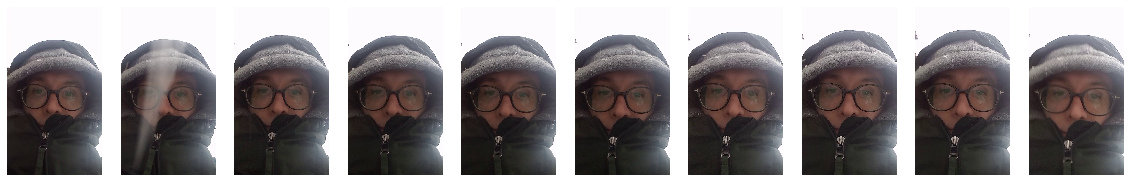

In [4]:
fig, ax = plt.subplots(ncols=print_debug, nrows=1, figsize=(20,20))
for seq, video_file in enumerate(video_files):
    vcap = cv2.VideoCapture(video_file)
    if vcap.isOpened():       
        for ind in range(print_debug):
            _, frame = vcap.read()
            frame = cv2.rotate(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), cv2.ROTATE_90_COUNTERCLOCKWISE)
            #frame = cv2.rotate(cv2.imread(frame_path), cv2.ROTATE_180)
            #frame = cv2.rotate(cv2.imread(frame_path), cv2.ROTATE_90_COUNTERCLOCKWISE)
            ax[ind].imshow(frame)
            ax[ind].axis('off')
            if ind == print_debug:
                break
        plt.show()

# Video upsampling

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

output_dir = '/home/gianscarpe/dev/event-camera/notebooks/outputs'
script_dir = '/home/gianscarpe/dev/rpg_vid2e/upsampling'


In [6]:
try:
    cur_dir = os.path.abspath(os.curdir)
    if os.path.exists(output_dir) and os.path.isdir(output_dir):
        shutil.rmtree(output_dir)
    os.chdir(script_dir)
    subprocess.call(["python","upsample.py", 
                 f"--input_dir={base_dir}", 
                 f"--output_dir={output_dir}", 
                 f"--device={device}"]) 
    os.chdir(cur_dir)
    if os.path.exists(base_dir) and os.path.isdir(base_dir):
        shutil.rmtree(base_dir)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

# Vid2events

In [7]:
Cp, Cn = 0.1, 0.1
refractory_period = 1e-4
log_eps = 1e-3
use_log = True
H, W = 1280 //5, 720 // 5
num_events_per_frame = 20000
events_output_dir = os.path.join(os.curdir, 'events')


In [8]:
esim = esim_py.EventSimulator(Cp, 
                              Cn, 
                              refractory_period, 
                              log_eps, 
                              use_log)
esim.setParameters(Cp, Cn, refractory_period, log_eps, use_log)
print(esim)

In [16]:
def constant_frame_representation(events):
    event_count_frame = np.zeros((out_H, out_W))
    for ind, event in enumerate(events):
        x = int(event[0])
        y = int(event[1])
        p = int(event[3])
        event_count_frame[x, y] +=1
        if ind % num_events_per_frame == 0:
            yield event_count_frame
            event_count_frame = np.zeros_like(event_count_frame)
    

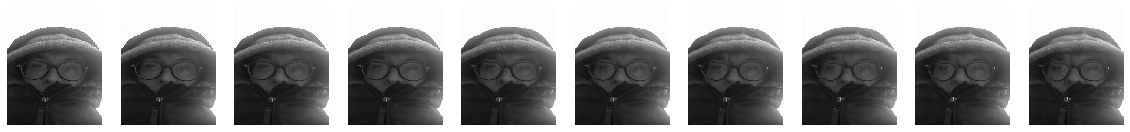

In [22]:
fig, ax = plt.subplots(ncols=print_debug, nrows=1, figsize=(20,20))
for seq in os.listdir(output_dir):
    seq_path = os.path.join(output_dir, seq)
    imgs_path = os.path.join(seq_path, 'imgs')
    
    for ind, frame_path in enumerate(sorted(glob.glob(os.path.join(imgs_path, "*.png")))[:20]):
        if ind == print_debug:
            break
        frame = cv2.rotate(cv2.imread(frame_path), cv2.ROTATE_90_COUNTERCLOCKWISE)
        ax[ind].imshow(frame)
        ax[ind].axis('off')

    plt.show()

In [21]:
def voxel_representation(events, B):
    event_count_frame = np.zeros((out_W, out_H, B))
    t0 = events[0][2]
    dt = events[num_events_per_frame-1][2] - t0
    
    for ind, event in enumerate(events):
        x = int(event[0])
        y = int(event[1])
        ti = event[2]
        p = int(event[3])
        
        t = (B - 1) / dt * (ti - t0)
        for tn in range(B):  
            event_count_frame[x, y, tn] += p * max(0, 1 - abs(tn - t))
            
        if ind % num_events_per_frame == 0:
            yield event_count_frame
            event_count_frame = np.zeros_like(event_count_frame)
            t0 = events[ind][2]
            end_index = min(len(events)-1, ind+num_events_per_frame-1)
            dt = events[end_index][2] - t0
            

In [23]:
for seq in os.listdir(output_dir):
    seq_path = os.path.join(output_dir, seq)
    imgs_path = os.path.join(seq_path, 'imgs')
    ts_path = os.path.join(seq_path, 'timestamps.txt')
    events_output_path = os.path.join(events_output_dir, seq)
    os.makedirs(events_output_path, exist_ok = True)
        
    events = esim.generateFromFolder(imgs_path, ts_path)
    for ind, frame in enumerate(voxel_representation(events, voxel_bins)):
        np.save(os.path.join(events_output_path, f"frame{ind}.npy"), frame)


In [39]:
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    shutil.rmtree(output_dir)

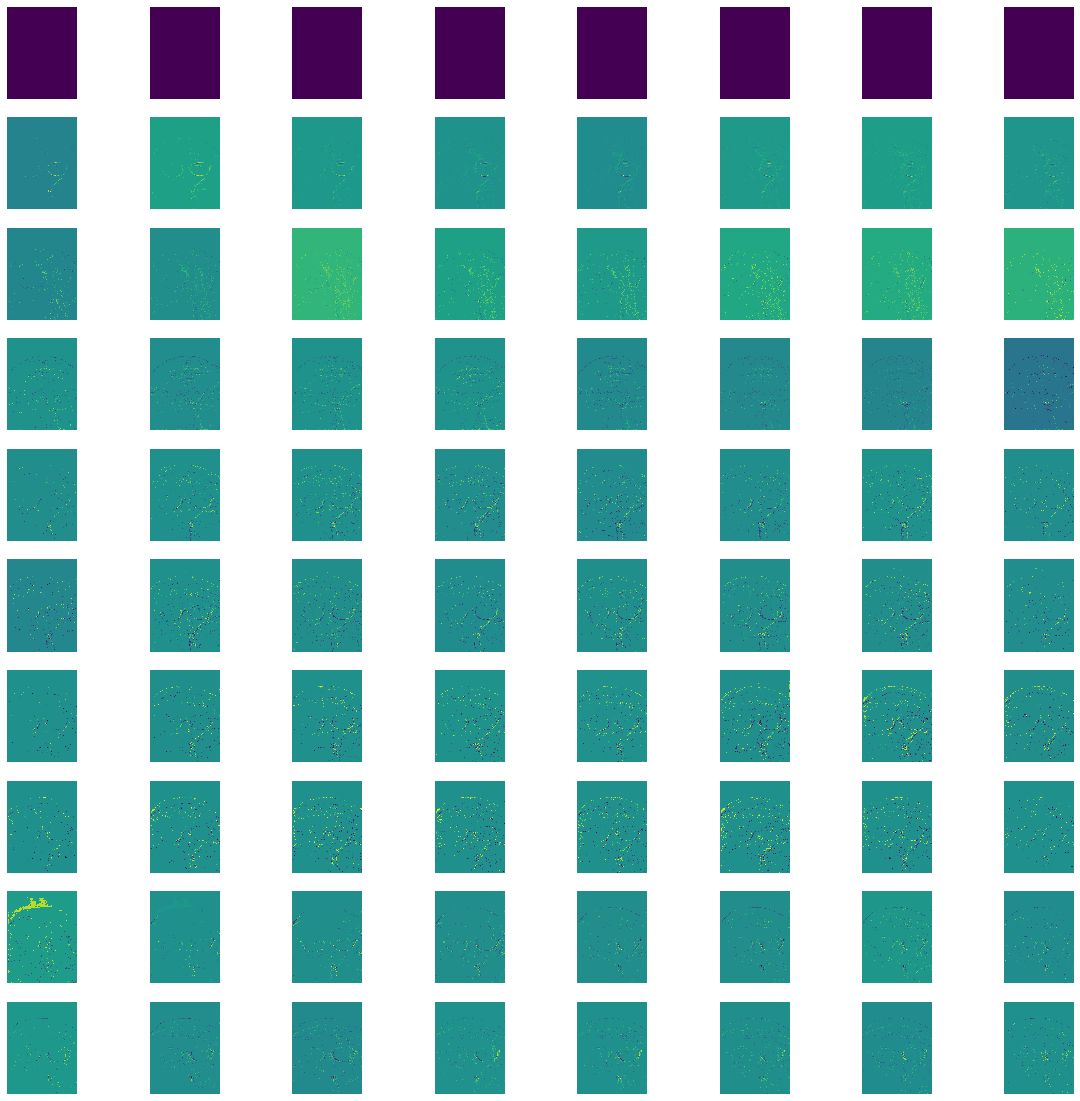

In [38]:
fig, ax = plt.subplots(ncols=voxel_bins , nrows=print_debug, figsize=(20,20))
for ind, frame_path in enumerate(sorted(glob.glob(os.path.join(events_output_path, "*.npy")))[:print_debug]):
    frame = cv2.rotate(np.load(frame_path), cv2.ROTATE_180)
    for i in range(voxel_bins):
        ax[ind, i].imshow(frame[:, :, i])
        ax[ind, i].axis('off')
plt.show()